In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
figsize(20, 10)

In [123]:
import json
import webdataset as wds
import dbm
import dbm.ndbm
import shelve
import os
import os.path
import glob
import random
from ocropus import ocroseg, models, utils, loading
import scipy.ndimage as ndi
import torch
import skimage
import skimage.filters

In [18]:
model = loading.load_or_construct_model("publaynet-model.pth")
model.cuda(0)
model.eval()

Sequential(
  (0): GrayDocument(noise=0.0, autoinvert=True)
  (1): Input(BDHW->BDHW torch.float32 (0, 1) cuda:0 [None, 1, None, None])
  (2): InputStats(segmodel (n=8436379) dims [1,1] [1,1] [431,1224] [391,855] min [0,0] max [1,1] mean [0.0023,0.499] std [0.0372,0.485])
  (3): ModPad(16)
  (4): UnetLayer(
    (conv): Conv2d(1, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (up): ConvTranspose2d(120, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (sub): UnetLayer(
      (conv): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (up): ConvTranspose2d(160, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (sub): UnetLayer(
        (conv): Conv2d(60, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (do

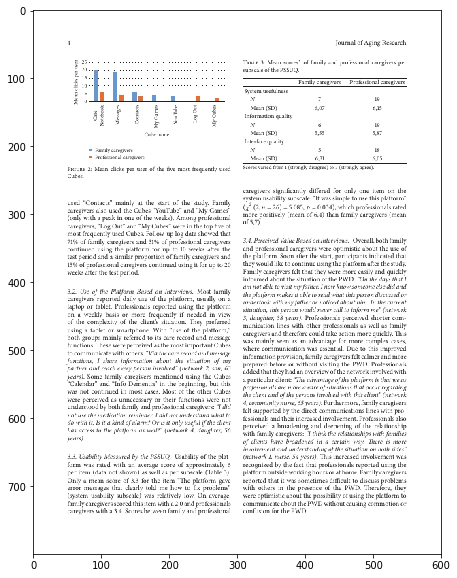

In [94]:
from itertools import islice
ds = wds.WebDataset("publaynet/publaynet-test-000000.tar").decode("rgb")
n = 15
sample = next(islice(iter(ds), n, 999999))
imshow(sample["png"])

In [95]:
image = 1-torch.tensor(sample["png"]).permute(2, 0, 1).unsqueeze(0)
image.shape

torch.Size([1, 3, 800, 601])

In [140]:
with torch.no_grad():
    output = model(image).detach().cpu()[0].softmax(0).numpy().transpose(1, 2, 0)

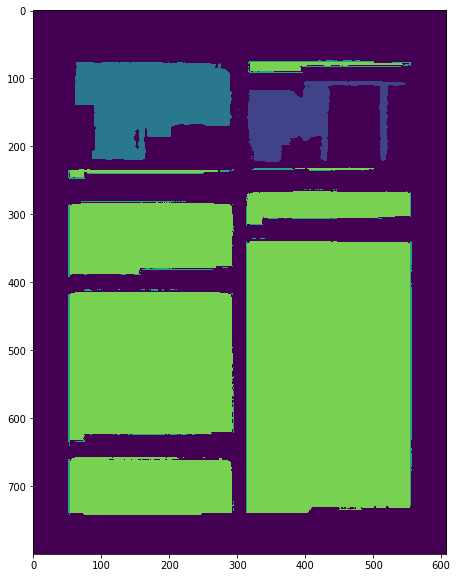

In [143]:
imshow(np.argmax(output, 2) * (np.amax(output, 2) > 0.8), cmap=cm.viridis, vmax=5)

0.999991


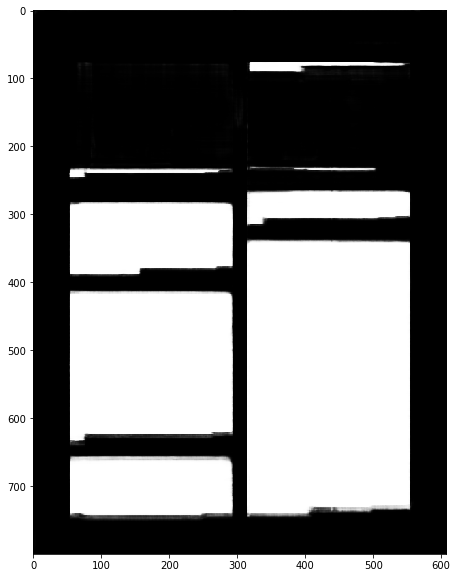

In [153]:
imshow(output[...,4])
print(amax(output[...,4]))

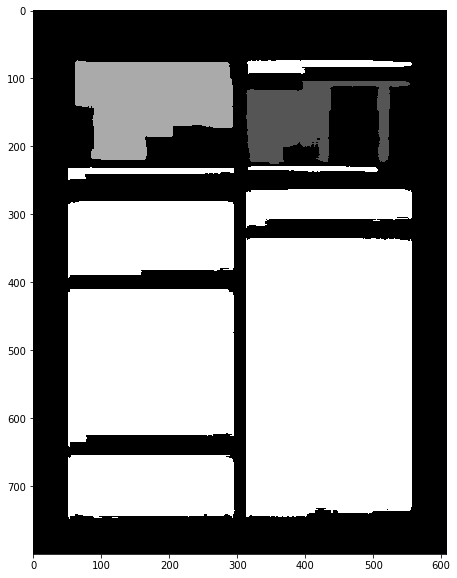

In [211]:
tables = skimage.filters.apply_hysteresis_threshold(output[...,1], 0.3, 0.9)
images = skimage.filters.apply_hysteresis_threshold(output[...,2], 0.3, 0.9)
markers = skimage.filters.apply_hysteresis_threshold(output[...,4], 0.3, 0.9)
regions = skimage.filters.apply_hysteresis_threshold(maximum(output[...,3], output[...,4]), 0.3, 0.9)
text = ocroseg.marker_segmentation(markers, regions,maxdist=20)
combo = where(text, 3, where(images, 2, where(tables, 1, 0)))
imshow(combo)

In [212]:
def bboxes(a):
    return ndi.find_objects(ndi.label(a)[0])

In [230]:
text_obj = bboxes(text)
table_obj = bboxes(tables)
img_obj = bboxes(images)

In [218]:
text_obj

[(slice(74, 94, None), slice(315, 556, None)),
 (slice(230, 238, None), slice(316, 507, None)),
 (slice(231, 250, None), slice(52, 296, None)),
 (slice(263, 320, None), slice(313, 556, None)),
 (slice(281, 394, None), slice(52, 295, None)),
 (slice(336, 746, None), slice(313, 556, None)),
 (slice(411, 643, None), slice(51, 295, None)),
 (slice(654, 748, None), slice(52, 296, None))]

In [214]:
def intersection(a, b):
    start = max(a.start, b.start)
    stop = min(a.stop, b.stop)
    if start > stop:
        return None
    else:
        return slice(start, stop)
    
def intersections(a, b):
    result = list(map(intersection, a, b))
    if None in result:
        return None
    else:
        return result
    
    
def union(a, b):
    start = min(a.start, b.start)
    stop = max(a.stop, b.stop)
    if start > stop:
        return None
    else:
        return slice(start, stop)
    
def unions(a, b):
    result = list(map(union, a, b))
    if None in result:
        return None
    else:
        return result

In [231]:
def intersects_any(x, bg):
    for y in bg:
        if intersections(x, y) is not None:
            return True
    return False

def mergeall(fg, bg):
    fg = fg.copy()
    result = []
    while len(fg) > 0:
        a = fg.pop(0)
        print(a)
        i = 0
        while i < len(fg):
            b = fg[i]
            u = unions(a, b)
            if intersects_any(u, bg):
                i = i+1
            else:
                a = u
                del fg[i]
        print(">", a)
        result.append(a)    
    return result
        
textobj = mergeall(text_obj, table_obj+img_obj)
tableobj = mergeall(table_obj, text_obj+img_obj)
imgobj = mergeall(img_obj, text_obj+table_obj)

(slice(74, 94, None), slice(315, 556, None))
> (slice(74, 94, None), slice(315, 556, None))
(slice(230, 238, None), slice(316, 507, None))
> [slice(230, 748, None), slice(51, 556, None)]
(slice(104, 226, None), slice(313, 553, None))
> (slice(104, 226, None), slice(313, 553, None))
(slice(74, 221, None), slice(61, 294, None))
> (slice(74, 221, None), slice(61, 294, None))


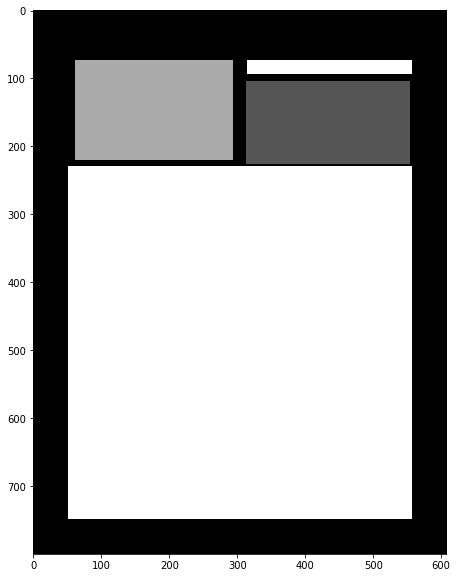

In [232]:
z = zeros(output.shape[:2])
for s in textobj: z[tuple(s)] = 3
for s in tableobj: z[tuple(s)] = 1
for s in imgobj: z[tuple(s)] = 2
imshow(z)